In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

## Data Import and Processing

In [20]:
X = np.loadtxt('training_data/training_samples.txt')
y = np.loadtxt('training_data/chisqs.txt')

In [21]:
val_frac, test_frac = 0.2, 0.2
total = val_frac + test_frac

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=total, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_frac/total), random_state=42)

## Model Creation and Training

### Without normalization layer

In [22]:
tf.keras.utils.set_random_seed(42)

input_layer = tf.keras.layers.Input(shape=X_train.shape[1:])

temp_model = tf.keras.Sequential([
    input_layer,
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
temp_model.compile(loss='mse', optimizer=optimizer, metrics=["MeanSquaredError"])

stop_early = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
temp_history = temp_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=0)

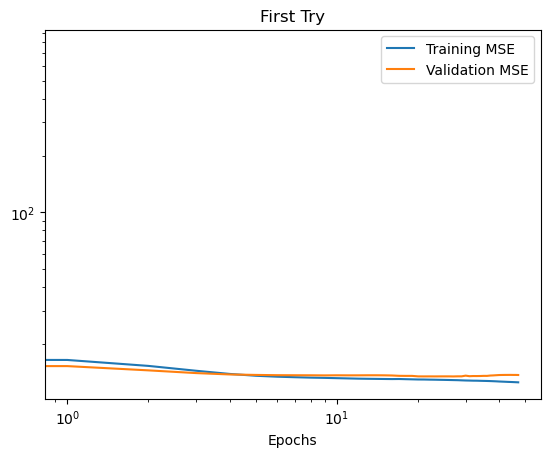

In [23]:
plt.plot(temp_history.history['loss'], label='Training MSE')
plt.plot(temp_history.history['val_loss'], label='Validation MSE')
plt.xscale('log')
plt.yscale('log')
plt.title('First Try')
plt.legend()
plt.xlabel('Epochs')

plt.savefig('plots/First_Try.png',dpi=300,bbox_inches='tight')

In [24]:
temp_test_loss, temp_test_mse = temp_model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - MeanSquaredError: 12.7527 - loss: 12.7596


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


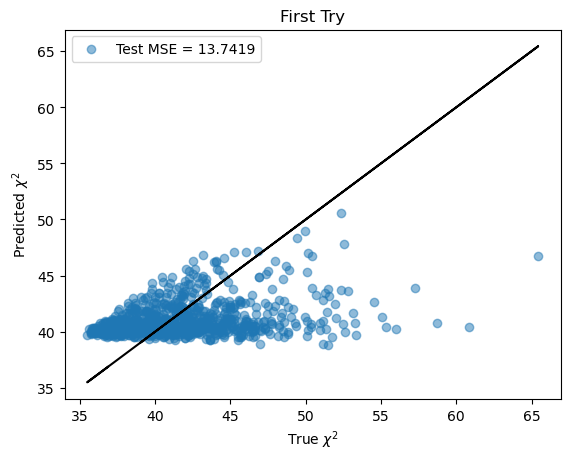

In [25]:
plt.scatter(y_test, temp_model.predict(X_test), label=f'Test MSE = {temp_test_mse:.4f}', alpha=0.5)
plt.plot(y_test, y_test, marker=' ', c='k')
plt.ylabel('Predicted $\chi^2$')
plt.xlabel('True $\chi^2$')
plt.title('First Try')
plt.legend()
plt.savefig('plots/First_Try_Test.png',dpi=300,bbox_inches='tight')

### With normalization layer

In [26]:
tf.keras.utils.set_random_seed(42)

input_layer = tf.keras.layers.Input(shape=X_train.shape[1:])
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)

model = tf.keras.Sequential([
    input_layer,
    norm_layer,
    tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=optimizer, metrics=["MeanSquaredError"])

stop_early = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=0)

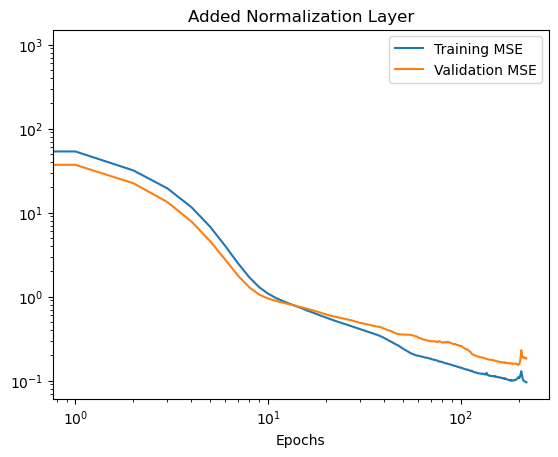

In [27]:
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xscale('log')
plt.yscale('log')
plt.title('Added Normalization Layer')
plt.legend()
plt.xlabel('Epochs')
plt.savefig('plots/Added_Normalization_Layer.png',dpi=300,bbox_inches='tight')

In [28]:
init_test_loss, init_test_mse = model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MeanSquaredError: 0.1594 - loss: 0.1739


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


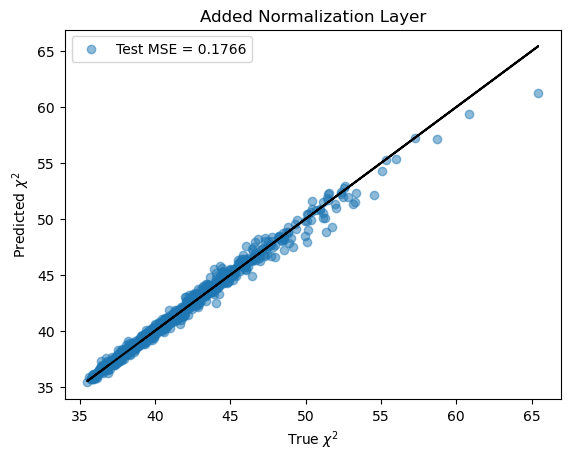

In [29]:
plt.scatter(y_test, model.predict(X_test), label=f'Test MSE = {init_test_mse:.4f}', alpha=0.5)
plt.plot(y_test, y_test, marker=' ', c='k')
plt.ylabel('Predicted $\chi^2$')
plt.xlabel('True $\chi^2$')
plt.title('Added Normalization Layer')
plt.legend()
plt.savefig('plots/Added_Normalization_Layer_Test.png',dpi=300,bbox_inches='tight')

### Tuned Model

In [30]:
tf.keras.utils.set_random_seed(42)

input_layer = tf.keras.layers.Input(shape=X_train.shape[1:])
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)

best_model = tf.keras.Sequential([
    input_layer,
    norm_layer,
    tf.keras.layers.Dense(400, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(100, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(100, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
best_model.compile(loss='mse', optimizer=optimizer, metrics=["MeanSquaredError"])

stop_early = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=0)

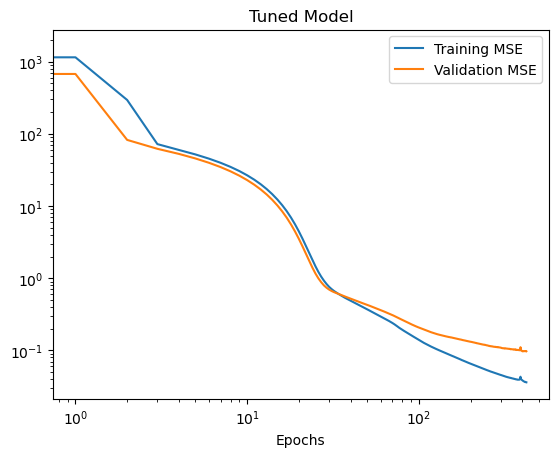

In [31]:
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xscale('log')
plt.yscale('log')
plt.title('Tuned Model')
plt.legend()
plt.xlabel('Epochs')
plt.savefig('plots/Tuned_Model.png',dpi=300,bbox_inches='tight')

In [32]:
best_test_loss, best_test_mse = best_model.evaluate(X_test, y_test)

 4/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MeanSquaredError: 0.0610 - loss: 0.0962 2

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MeanSquaredError: 0.0850 - loss: 0.1103


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


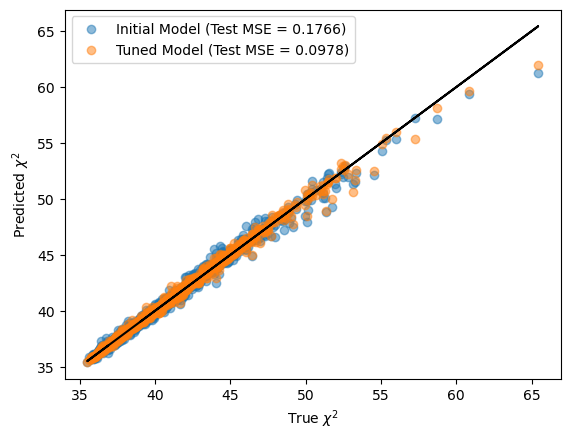

In [33]:
plt.scatter(y_test, model.predict(X_test), label=f'Initial Model (Test MSE = {init_test_mse:.4f})', alpha=0.5)
plt.scatter(y_test, best_model.predict(X_test), label=f'Tuned Model (Test MSE = {best_test_mse:.4f})', alpha=0.5)
plt.plot(y_test, y_test, marker=' ', c='k')
plt.ylabel('Predicted $\chi^2$')
plt.xlabel('True $\chi^2$')
plt.legend()
plt.savefig('plots/Tuned_Model_Test.png',dpi=300,bbox_inches='tight')

In [ ]:
#best_model.save('script_chisq_emulator_256_32.keras')